# North Atlantic O2 gapfill
    - Version 1.3
    - "isopycnal" model, no depth information is entered into the ML model
    - Omits month below the surface mixed layer
    - Absolute magnitude of O2 is estimated as a function of T, S, long, lat, and time (year, month)
    - Reads in the data from WOD profiles
    - Separates the data into training and test data (75% - 25%)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import os
import warnings
warnings.filterwarnings('ignore')

### First prepare O2, T, S, stratification data

In [2]:
# version information
ver = 1.3

In [3]:
# observational data 
# -------------------------------------------------------------
# Needs adjustment: this is where you write out the output files
diro = '/glade/scratch/ito/WOD18_OSDCTD/'
# -------------------------------------------------------------
dirf = '/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
fmer='_1x1bin_merged_'
var=['o2','TSN2']
os.system('mkdir -p '+diro)
os.system('mkdir -p '+diro+'temp')

0

In [4]:
dwoa=xr.open_dataset('/glade/campaign/univ/ugit0034/woa18/woa18_all_o00_01.nc',decode_times=False)

In [5]:
# basin mask
dsm=xr.open_dataset('/glade/campaign/univ/ugit0034/wod18/basin_mask_01.nc')
#! cp /glade/work/ito/basin_mask_01.nc /glade/campaign/univ/ugit0034/wod18/.

In [6]:
# obtain vertical grid
ds=xr.open_dataset(diro+var[0]+fmer+str(1965)+'.nc')
Z=ds.depth.to_numpy()
Nz=np.size(Z)
print(Nz)
#
# cutoff depth
zoff = 100
#
# select analysis period
# do not change the start year from 1965 (this is when Carpenter 1965 established modern Winkler method)
yrs=np.arange(1965,2011,1)

47


In [7]:
#
# Obtain TS data from observational gridded dataset
#
Nyr=np.size(yrs)
Nt=Nyr*12
mon=["%.2d" % i for i in np.arange(1,13,1)]
#
o2=np.zeros((Nt,Nz,180,360))
t=np.zeros((Nt,Nz,180,360))
s=np.zeros((Nt,Nz,180,360))
mld=np.zeros((Nyr,12,180,360))
#
for year in yrs:
    ytmp=year%10
    if ytmp==0:
        print(str(year))
    ds=xr.open_dataset(diro+var[0]+fmer+str(year)+'.nc')
    tr=12*(year-1965)
    o2[tr:(tr+12),:,:,:]=ds.o2.to_numpy()
    #
    #option 2. use EN4 for training#
    for mn in range(12):
        ds = xr.open_dataset(dirf+'EN4_TSN2_L09_180x360_'+str(year)+mon[mn]+'.nc')
        s[tr+mn,:,:,:]=ds.SA.interp(depth=Z).to_numpy().squeeze()
        t[tr+mn,:,:,:]=ds.CT.interp(depth=Z).to_numpy().squeeze()
        mld[year-1965,mn,:,:]=ds.MLD_125.to_numpy().squeeze()

1970
1980
1990
2000
2010


In [8]:
mldc=np.mean(mld,axis=0)

In [9]:
# get coordinates
x=ds.lon.to_numpy()
y=ds.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [10]:
# extract mask in the Atlantic basin
mask= dsm.basin_mask.sel(depth=Z)

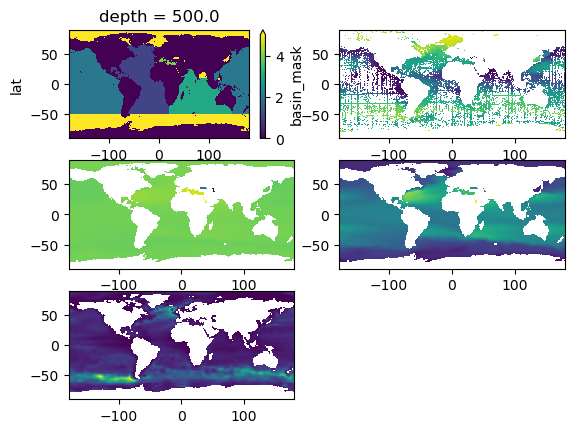

In [11]:
# take a look at the data
fig,ax=plt.subplots(3,2)
# select 500m for plotting
kind=[idx for idx,elem in enumerate(Z) if elem==500]
#
mask.isel(depth=kind).plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
ax[0,1].pcolormesh(x,y,np.nanmean(o2[:,kind[0],:,:],axis=0))
ax[1,0].pcolormesh(x,y,np.nanmean(s[:,kind[0],:,:],axis=0))
ax[1,1].pcolormesh(x,y,np.nanmean(t[:,kind[0],:,:],axis=0))
ax[2,0].pcolormesh(x,y,np.nanmean(mldc,axis=0))
ax[2,1].remove()

In [12]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=Z).to_numpy()

In [13]:
# climatological mld
mldc1 = np.tile(mldc,[Nyr,1,1])
mld1 = np.tile(mldc1,[Nz,1,1,1])
mld1  = np.transpose(mld1,(1,0,2,3))+zoff

In [14]:
# make numpy array
doa = o2
dsa = s
dta = t
#
# prepare depth lat lon time data
xx1 = np.tile(xx,[Nt,Nz,1,1])
yy1 = np.tile(yy,[Nt,Nz,1,1])
ztmp = np.tile(Z,[Nt,180,360,1])
zz1 = np.transpose(ztmp,[0,3,1,2])
t0=np.arange(0,Nt,1)
t1=t0%12
#
tt0 = np.tile(t0,[Nz,180,360,1])
tt1 = np.transpose(tt0,(3,0,1,2))
tc0 = np.tile(t1,[Nz,180,360,1])
tc1 = np.transpose(tc0,(3,0,1,2))

In [15]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)

### Now we have the data for the North Atlantic. Remove NaNs and organize them into 1d array

In [16]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()
tc0  = tc1.flatten()
zz0  = zz1.flatten()
ml0  = mld1.flatten()

In [17]:
# remove nan
dd = doa0 + dsa0 + dta0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
zz1=zz0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
tc1=tc0[np.isnan(dd)==False]
ml1=ml0[np.isnan(dd)==False]
# clim MLD + cutoff, deeper layer is set to 2 = March
tc1=np.where(zz1<ml1,tc1,2)
#
Nsample = np.size(doa1)
print(Nsample)

1150129


### This is where we choose what variables to include

In [18]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, xx1, yy1, tt1, tc1])
#X = np.array([dsa1, dta1, xx1, yy1, zz1, tt1, tc1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

In [19]:
#np.savez(f'ML_params_v{ver}.npz',Xm=Xm,Xstd=Xstd,ym=ym,ystd=ystd)

## ML

### First split the data into training and test set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1)

### MLR estimator (MLregr)

In [21]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [22]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

In [23]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
MLregr.get_params()

0.6545557178274907


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

correlation =  0.8090763720292992
RMSE =  32.99395132549836


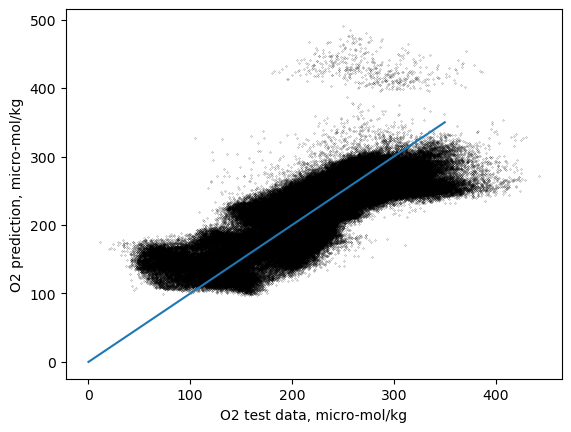

In [24]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

### Random Forest Regressor (RFregr)

In [25]:
##
## RF
##
from sklearn.ensemble import RandomForestRegressor

In [26]:
#RFregr = RandomForestRegressor(n_estimators=500,min_samples_leaf=12,max_features=3)
RFregr = RandomForestRegressor()
RFregr.fit(X_train, y_train)

RandomForestRegressor()

In [27]:
out = RFregr.predict(X_test)
RFregr.score(X_test, y_test)
#RFregr.get_params()

0.9719806884479484

R2 =  0.9719938000328662
RMSE =  9.396671730716221


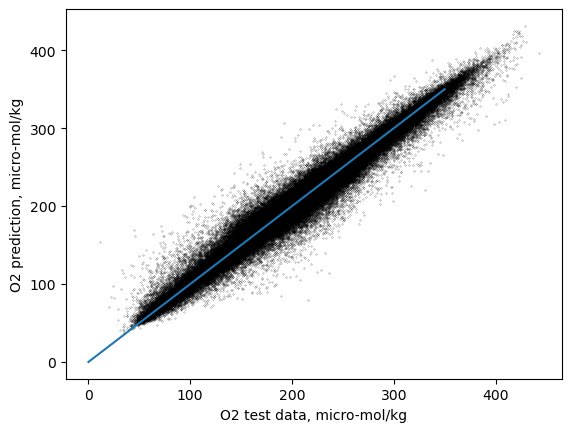

In [28]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_RF=temp[0,1]
print('R2 = ',Rval_RF**2)
RMSE_RF=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_RF)
#
o2test_RF = o2test.copy()
o2est_RF = o2est.copy()

### Neural Network estimator (NNregr)

In [29]:
## NN
from sklearn.neural_network import MLPRegressor

In [30]:
NNregr = MLPRegressor(hidden_layer_sizes=(10,10,10,10),alpha=0.01, 
                      random_state=1, max_iter=1000).fit(X_train, y_train)

In [31]:
out = NNregr.predict(X_test)
NNregr.score(X_test, y_test)

0.9118857925494042

correlation =  0.9560652263874656
RMSE =  16.663579381738824


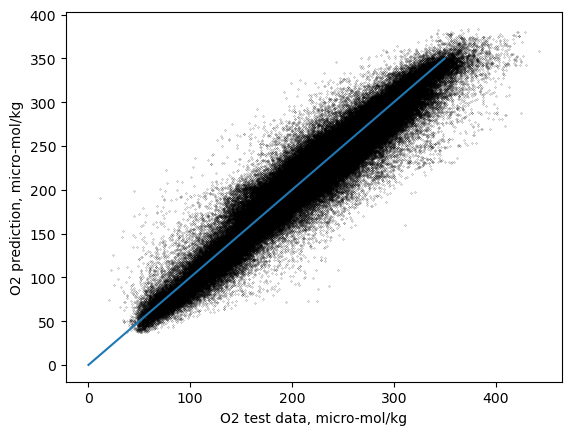

In [32]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)
o2test_NN = o2test.copy()
o2est_NN = o2est.copy()

In [33]:
#import joblib
#filename = f'NN_model_v{ver}.sav'
#joblib.dump(NNregr, filename)

In [34]:
#filename = f'RF_model_v{ver}.sav'
#joblib.dump(RFregr, filename)

In [35]:
#filename = f'MLR_model_v{ver}.sav'
#joblib.dump(MLregr, filename)

In [36]:
#np.save('mldc.npy',mldc)

In [37]:
np.savez('o2test_pred.npz',NNtest=o2test_NN,NNest=o2est_NN,RFtest=o2test_RF,RFest=o2est_RF)